# Import modules and notebook settings

In [1]:
# Keep modules updated if they change within the session
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Load modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import squidpy as sq
import anndata as ad
import scanpy as sc
import scipy as sp
import scanorama as scan

# Settings
import warnings
warnings.filterwarnings('ignore')
#sc.settings.set_figure_params(dpi=80)

# Print versions
sc.logging.print_header()
print(f"squidpy=={sq.__version__}")

2023-02-08 22:39:04.899043: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-08 22:39:04.985555: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-08 22:39:05.468244: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-08 22:39:05.468288: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.22.4 scipy==1.10.0 pandas==1.5.2 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.3 louvain==0.7.1 pynndescent==0.5.8
squidpy==1.2.3


# User input

In [2]:
# The user must choose 3 fluorophore channels to use as RGB raster format
user_input_channels = ['145_CD45', '174_CK', '113_vimentin'] #, '167_CD8', '143_CD4']
image_dir = '../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_colon_images/'
segmentation_dir = '../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/segmentation/'

# Create AnnData object

### If downstream analysis includes NCEM, the raw data file and folder structure must be structured in the following manner:
- Current required structure for seamless functionality:
 
    - **Root folder** (e.g. Hartmann-2021)
        - **scMEP_sample_description.xlsx** ---- metadata
        - **scMEP_MIBI_singlecell/**
            - **main_matrix.csv** ---- counts and obs matrix
            - **scMEP_MIBI_colon_images/**
                - **donor_id_folders/** ---- 1 folder per donor/sample; e.g. "90de/"
                   - **image_id folders**
                       - image_files.tif ---- 1 image file per marker/feature/channel; e.g. 147_vimentin.tif
            - **segmentation/**
                 - **segmentation_files.tif** ---- e.g. Point1_Label_Map.tif


- The reason is that the NCEM package uses `DataLoader<Author>()` classes ([link to github source code](https://github.com/theislab/ncem/blob/1ed3ccead38f70fcdbcc6640971ddfa877ff62cd/ncem/data.py#L2278))
- In our specific case we use the `DataLoaderHartmann()` class which is called behind by the `interpreter.get_data()` function
- The authors state their desire to implement a custom `DataLoader()` class in the future.

# Prepare the data

In [3]:
# Annotations come in a single matrix
data_unformatted = pd.read_csv("../input-data/raw-data/Hartmann-2021/scMEP_MIBI_singlecell/scMEP_MIBI_singlecell.csv")
data_unformatted = data_unformatted.dropna(axis=0)

# Some manual matrix formatting
data_unformatted['library_id'] = 'Point' + data_unformatted['point'].astype(str)
data_unformatted['new_index'] = data_unformatted['library_id'].astype(str) + '_' + data_unformatted['cell_id'].astype(str)
data_unformatted = data_unformatted.set_index(pd.Index(data_unformatted['new_index'].to_numpy()))
data_unformatted = data_unformatted.drop('new_index', axis=1)
# Data point coordinates can be converted to using specific scalefactor e.g. 400um/1024px but current workflow relies on then being in the pixel space
# data_unformatted['center_colcoord'] = data_unformatted['center_colcoord'].apply(lambda x: 400 / 1024 * x)
# data_unformatted['center_rowcoord'] = data_unformatted['center_rowcoord'].apply(lambda x: 400 / 1024 * x)

# Subset and format to adjust to AnnData format
counts = data_unformatted.iloc[:, 3:39].copy()

## Due to AnnData bugs (2022-12-05) we need to either supply a numpy.array or recently created pandas.DataFrame
X = pd.DataFrame(
        counts.to_numpy(),
        columns = list(counts.columns),
        index = list(counts.index)
)
obs = data_unformatted.iloc[:, np.r_[0:3, 39:len(data_unformatted.columns)]].copy()
obs['diagnosis'] = pd.Categorical(
    np.where(
        np.in1d(obs['donor'], ['90de', '21d7']), 
        'Colorectal carcinoma', 
        'Healthy'
    )
)

# adata.obsm: Spatial location of spots
obsm = {
    'spatial': data_unformatted.loc[:, ['center_colcoord', 'center_rowcoord']].to_numpy()
}

# adata.uns: Metadata
sample_info = pd.read_excel(
    "../input-data/raw-data/Hartmann-2021/scMEP_sample_description.xlsx",
).to_dict(orient='list')

uns = {
    'sample_info': sample_info,
    'Cluster_colors': [
        '#1f77b4',
        '#ff7f0e',
        '#2ca02c',
        '#d62728',
        '#9467bd',
        '#8c564b',
        '#e377c2',
        '#7f7f7f'
      ]
}


### Create the object

In [4]:
# Create AnnData object
adata = ad.AnnData(
    X = X, 
    obs = obs, 
    obsm = obsm,
    uns = uns
)

# Remove observations that belong to an empyt point
adata = adata[~np.isnan(adata.obsm["spatial"][:, 0])].copy()

# For future layer
adata_raw = adata.X

adata

AnnData object with n_obs × n_vars = 63734 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'library_id', 'diagnosis'
    uns: 'sample_info', 'Cluster_colors'
    obsm: 'spatial'

In [5]:
adata.to_df()

,H3,vimentin,SMA,CD98,NRF2p,CD4,CD14,CD45,PD1,CD31,...,CD8,CD57,LDHA,IDH2,HK1,Ecad,CPT1A,CK,NaKATPase,HIF1A
Point7_2,0.785881,0.408300,0.696414,0.000000,0.600454,0.000000,0.572489,0.071873,0.000000,0.000000,...,0.000000,0.000000,0.344579,0.502285,0.161829,0.269818,0.324649,0.000000,0.000000,0.000000
Point7_6,0.762130,0.727941,0.692685,0.000000,0.126400,0.000000,0.330630,0.474050,0.000000,0.000000,...,0.468677,0.070334,0.409235,0.481462,0.312938,0.094715,0.354284,0.000000,0.000000,0.000000
Point7_8,0.718484,0.321032,0.270971,0.379427,0.728447,0.239057,0.131221,0.192857,0.000000,0.000000,...,0.033525,0.157202,0.537986,0.543015,0.091759,0.322762,0.443656,0.284286,0.447547,0.000000
Point7_9,0.844099,0.595707,0.643885,0.334527,0.134485,0.531027,0.195556,0.670235,0.053552,0.000000,...,0.114762,0.000000,0.609270,0.499102,0.479794,0.294011,0.444598,0.000000,0.256981,0.106809
Point7_14,0.733856,0.652953,0.461541,0.589736,0.484765,0.356065,0.386779,0.439137,0.000000,0.287635,...,0.019767,0.000000,0.618623,0.557943,0.384368,0.477327,0.559286,0.396537,0.682852,0.204079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Point25_1124,0.606688,0.693328,0.482057,0.000000,0.417442,0.348995,0.499925,0.209032,0.000000,0.000000,...,0.000000,0.000000,0.648503,0.507011,0.117075,0.351623,0.378172,0.000000,0.459636,0.000000
Point25_1125,0.803571,0.704590,0.541540,0.543553,0.276144,0.571832,0.672874,0.727685,0.563716,0.000000,...,0.000000,0.000000,0.663256,0.624918,0.662077,0.394823,0.406933,0.000000,0.494732,0.000000
Point25_1126,0.748780,0.485276,0.868089,0.000000,0.525238,0.263389,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.599062,0.625642,0.426509,0.393277,0.447733,0.000000,0.000000,0.000000
Point25_1127,0.831164,0.812797,0.561337,0.101062,0.578004,0.136832,0.034396,0.000000,0.000000,0.885439,...,0.000000,0.000000,0.650302,0.668709,0.349704,0.379485,0.453863,0.000000,0.336142,0.000000


In [6]:
adata.obs

,row_num,point,cell_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,library_id,diagnosis
Point7_2,0,7,2,63894.0,109.0,6.0,277.0,carcinoma,90de,Imm_other,Point7,Colorectal carcinoma
Point7_6,3,7,6,63898.0,845.0,5.0,298.0,carcinoma,90de,Imm_other,Point7,Colorectal carcinoma
Point7_8,4,7,8,63900.0,997.0,17.0,2037.0,carcinoma,90de,Epithelial,Point7,Colorectal carcinoma
Point7_9,5,7,9,63901.0,192.0,13.0,611.0,carcinoma,90de,Tcell_CD4,Point7,Colorectal carcinoma
Point7_14,9,7,14,63906.0,913.0,17.0,1616.0,carcinoma,90de,Myeloid_CD68,Point7,Colorectal carcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...
Point25_1124,66394,25,1124,50571.0,890.0,1016.0,219.0,carcinoma,21d7,Imm_other,Point25,Colorectal carcinoma
Point25_1125,66395,25,1125,50572.0,492.0,1018.0,238.0,carcinoma,21d7,Tcell_CD4,Point25,Colorectal carcinoma
Point25_1126,66396,25,1126,50573.0,618.0,1019.0,283.0,carcinoma,21d7,Fibroblast,Point25,Colorectal carcinoma
Point25_1127,66397,25,1127,50574.0,65.0,1019.0,138.0,carcinoma,21d7,Endothelial,Point25,Colorectal carcinoma


# Preprocessing

In [7]:
# Correct batches (Points) | Inspiration from Squidpy preprocessing pipeline "https://github.com/theislab/squidpy_reproducibility/blob/master/notebooks/prepare_data/ionpath.ipynb"
def splitBatches(adata, batch, hvg=None):
    split = []
    if hvg is not None:
        adata = adata[:, hvg]
    for i in adata.obs[batch].unique():
        adata_split = adata[adata.obs[batch] == i].copy()
        adata_split.X = sp.sparse.csr_matrix(adata_split.X.copy())
        sc.pp.scale(adata_split)
        split.append(adata_split)
    return split

In [8]:
# To keep uncorrected data as a layer
adata_uncorrected = adata.copy().X

# Correction
split = splitBatches(adata, batch="point")
corrected_list = scan.correct_scanpy(split, return_dimred=True)

corrected = corrected_list[0].concatenate(
    corrected_list[1:]
)

adata = corrected.copy()

Found 36 genes among all datasets
[[0.         0.0751604  0.07395498 ... 0.39257593 0.19890009 0.00641613]
 [0.         0.         0.14790997 ... 0.01799775 0.05       0.21743389]
 [0.         0.         0.         ... 0.05466238 0.06430868 0.07395498]
 ...
 [0.         0.         0.         ... 0.         0.46344207 0.04611924]
 [0.         0.         0.         ... 0.         0.         0.06078431]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Processing datasets (37, 55)
Processing datasets (5, 8)
Processing datasets (0, 5)
Processing datasets (5, 22)
Processing datasets (0, 9)
Processing datasets (22, 24)
Processing datasets (0, 22)
Processing datasets (54, 55)
Processing datasets (1, 3)
Processing datasets (18, 24)
Processing datasets (8, 22)
Processing datasets (27, 31)
Processing datasets (8, 24)
Processing datasets (7, 20)
Processing datasets (24, 56)
Processing datasets (49, 51)
Processing datasets (0, 37)
Processing datasets (11, 12)
Processing dat

In [11]:
# Add uncorrected and raw layers
adata.layers["raw"] = adata_raw
adata.uns = uns
adata.layers["uncorrected"] = adata_uncorrected

In [12]:
adata.obs

,row_num,point,cell_id,X1,center_rowcoord,center_colcoord,cell_size,category,donor,Cluster,library_id,diagnosis,batch
Point7_2-0,0,7,2,63894.0,109.0,6.0,277.0,carcinoma,90de,Imm_other,Point7,Colorectal carcinoma,0
Point7_6-0,3,7,6,63898.0,845.0,5.0,298.0,carcinoma,90de,Imm_other,Point7,Colorectal carcinoma,0
Point7_8-0,4,7,8,63900.0,997.0,17.0,2037.0,carcinoma,90de,Epithelial,Point7,Colorectal carcinoma,0
Point7_9-0,5,7,9,63901.0,192.0,13.0,611.0,carcinoma,90de,Tcell_CD4,Point7,Colorectal carcinoma,0
Point7_14-0,9,7,14,63906.0,913.0,17.0,1616.0,carcinoma,90de,Myeloid_CD68,Point7,Colorectal carcinoma,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Point25_1124-57,66394,25,1124,50571.0,890.0,1016.0,219.0,carcinoma,21d7,Imm_other,Point25,Colorectal carcinoma,57
Point25_1125-57,66395,25,1125,50572.0,492.0,1018.0,238.0,carcinoma,21d7,Tcell_CD4,Point25,Colorectal carcinoma,57
Point25_1126-57,66396,25,1126,50573.0,618.0,1019.0,283.0,carcinoma,21d7,Fibroblast,Point25,Colorectal carcinoma,57
Point25_1127-57,66397,25,1127,50574.0,65.0,1019.0,138.0,carcinoma,21d7,Endothelial,Point25,Colorectal carcinoma,57


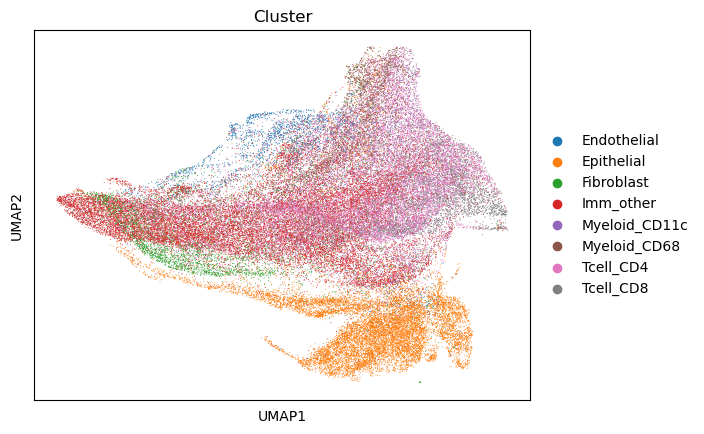

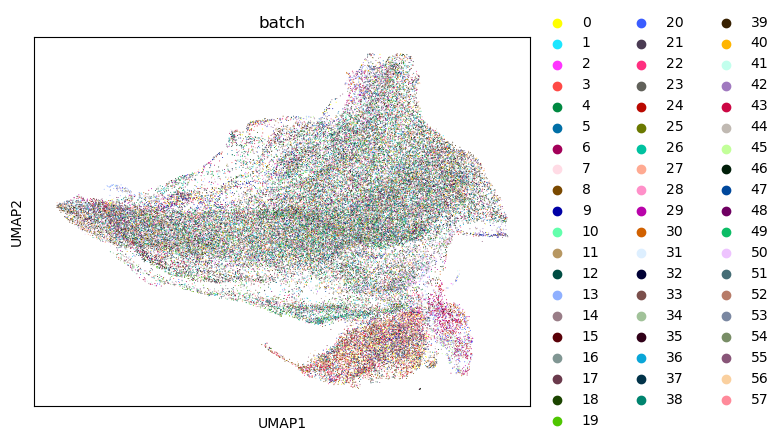

In [13]:
# UMAP
sc.pp.neighbors(adata, use_rep='X_scanorama')
sc.tl.umap(adata)

sc.pl.umap(adata, color=['Cluster'])
sc.pl.umap(adata, color=['batch'])

# Integrate image and segmentation mask data

### Algorithm initiation and adding images

 - This algorithm processes both images and segmentation masks separately
 - It also checks that the file names are correctly attributed based on `obs['library_id']`

In [14]:
def increase_contrast(arr, lower_thresh = 0, upper_thresh=0):
    '''
    Increase the contrast of an image by:
     - removing a lower threshold of values
     & assigning values above an upper threshold the maximum value
     & stretching the values to the entire uint8 space
    '''
    arr = (arr > lower_thresh) * arr
    arr = np.where(arr < upper_thresh, arr, [upper_thresh] * len(arr))
    arr = (arr - np.min(arr)) * (255 / (np.max(arr) - np.min(arr)))

    return arr

In [15]:
# Initialize the spatial dictionary
spatial_dict = {}

# Some variables
library_ids = adata.obs['library_id'].unique()

for donor in os.listdir(image_dir):

    donor_path = os.path.join(image_dir, donor)

    # Check if folder structure correct: layer 1
    if not os.path.isdir(donor_path):
        raise Exception('`image_dir` directory must only contain directories named after the donors.')
    
    # Check if folder names coincide with donor value in obs matrix
    elif not all(np.in1d(donor, adata.obs['donor'].to_list())):
        raise Exception('First layer folders are not named as in obs[\'donor\']')
    
    else:

        # Define points/FOV
        points = sorted(os.listdir(donor_path))

        # Check that point names are found in the `obs['library_id']`
        if not all(np.in1d(points, library_ids)):
            raise Exception("Image file names must be named equal to library_ids")




        # Add images
        
        for point in points:
    
            # Init dict layer 1: 'library_id' = {images, scalefactors}
            spatial_dict[point] = {}

            # Init dict layer 2: 'images' = {hires, segmentation}
            spatial_dict[point]['images'] = {}
    
            # Fill 'image' key in layer 2
            # 3 channel images as RGB raster 
            # Read .tif data as array
            # channel_arr = np.array(
                # [plt.imread(os.path.join(donor_path, point, user_input_channels[i]) + ".tif") for i in range(len(user_input_channels))]
            # ).transpose(1, 2, 0)
            c1 = plt.imread(os.path.join(donor_path, point, user_input_channels[0]) + ".tif")
            c2 = plt.imread(os.path.join(donor_path, point, user_input_channels[1]) + ".tif")
            c3 = plt.imread(os.path.join(donor_path, point, user_input_channels[2]) + ".tif")

            # Image transformation

            ## Only one channel to have information per pixel
            c3 = c3
            c2= np.where((c3 > 0), 0, c2)
            c1= np.where((c3 > 0) | (c2 > 0), 0, c1)

            ## Scale and stretch values to 8bit dtype=uint8
            c1 = np.log1p(c1) * (255 / np.log1p(255))
            c2 = np.log1p(c2) * (255 / np.log1p(255))
            c3 = np.log1p(c3) * (255 / np.log1p(255))

            ## Change contrast
            c1 = increase_contrast(c1, 0, 200)
            c2 = increase_contrast(c2, 0, 90)
            c3 = increase_contrast(c3, 120, 180)

            # Combinatorial superimposition for pseudo CMYK space
            c1n = np.where(c3 > 120, c3, c2)
            c2n = np.where(c3 > 120, c3, c1)
            c3n = np.where(c2 > 80, c2, c1)

            # # Back to int
            c1n = c1.astype('int')
            c2n = c2.astype('int')
            c3n = c3.astype('int')
    
            channel_arr = np.array([c1n, c2n, c3n], dtype='uint8').transpose(1, 2, 0)

            spatial_dict[point]['images']['hires'] = channel_arr
    
            # Fill 'scalefactors' key in layer 1
            spatial_dict[point]['scalefactors'] = {
                'spot_diameter_fullres': 15,
                'tissue_hires_scalef': 1, # Can be set to a specific scalefactor e.g. 400um/1024px but current workflow relies on =1
            }

### Add segmentation data

- This algorithm processes both images and segmentation masks separately
- Checks the validity of the segmentation files by trying to attribute the their names to the corresponding image file names by string content.

- In the future maybe integrate two alterntive paths:
    - argument indicating a dictionary of file links
    - argument indicating the file name changes/presuffixes that apply to the image file name to arrive at the segmentation file name

In [16]:
# Check if segmentation file names contain the library_id
seg_files = sorted(os.listdir(segmentation_dir))

## Initiate segmentation-file-name to library_id dict
dict_seg_lib_id = {}

for seg_file in seg_files:

    seg_id = seg_file[:-15] ### !!! Can be improved via e.g. regular expressions

    if seg_id in set(library_ids):
        dict_seg_lib_id[seg_file] = seg_id

    else:
        raise Exception('All segmentation files must contain the of an image file which are based on obs[\'library_id\']')


# Add segmentation information
for key, value in dict_seg_lib_id.items():

    # Fill 'segmentation' key in layer 2
    spatial_dict[value]['images']['segmentation'] = plt.imread(segmentation_dir + key)
    
    # Add 'tissue_segmentation_scalef' key in layer 1
    spatial_dict[value]['scalefactors']['tissue_segmentation_scalef'] = 1

# testing: image correction

In [ ]:
# i = adata.uns['spatial']['Point8']['images']['hires'][:, :, 0]
# j = adata.uns['spatial']['Point8']['images']['hires'][:, :, 1]
# k = adata.uns['spatial']['Point8']['images']['hires'][:, :, 2]

In [ ]:
# plt.imshow(np.log1p(i))

In [ ]:
# plt.imshow(np.log1p(j))

In [ ]:
# plt.imshow(np.log1p(k))

In [ ]:
# k = k
# j = np.where((k>0), 0, j)
# i = np.where((k>0) | (j>0), 0, i)

In [ ]:
# plt.imshow(np.log1p(i))

In [ ]:
# plt.imshow(np.log1p(j))

In [ ]:
# plt.imshow(np.log1p(k))

In [ ]:
# a = np.log1p(i) * (255 / np.log1p(255))
# a = increase_contrast(a, 0, 200)
# plt.imshow(a)

In [ ]:
# b = np.log1p(j) * (255 / np.log1p(255))
# b = increase_contrast(b, 0, 90)
# plt.imshow(b)

In [ ]:
# c = np.log1p(k) * (255 / np.log1p(255))
# c = increase_contrast(c, 120, 180)
# plt.imshow(c)

In [ ]:
# c = c
# b = np.where((c>0), 0, b)
# a = np.where((b>0) | (c>0), 0, a)

In [ ]:
# x = np.where(c > 120, c, b)
# plt.imshow(x)

In [ ]:
# y = np.where(c > 120, c, a)
# plt.imshow(y)

In [ ]:
# z = np.where(b > 80, b, a)
# plt.imshow(z)

In [ ]:
# plt.imshow(np.array([x, y, z]).transpose(1,2,0))

In [ ]:
# plt.imshow(np.array([a, b, c]).transpose(1,2,0))

### Final segmentation integration

In [17]:
# Integrate spatial dictionary into adata
adata.uns['spatial'] = spatial_dict

# Save adata object

In [18]:
adata.write('../output-data/hartmann/hartmann.h5ad', compression='gzip')